## Homework 5 - Camera Caliberation

Student: Nguyen Thu Huyen - 190033

Notebook adapted from instructor's tutorial 5 - Camera Caliberation. 

In [2]:
pip install pyyaml==5.4.1

Note: you may need to restart the kernel to use updated packages.


In [3]:
#Import packages
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
import glob
import yaml

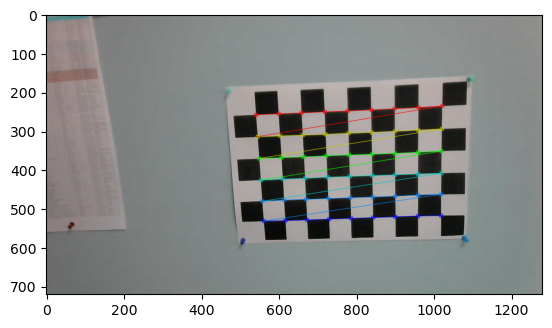

In [9]:
CHESSBOARD_CORNER_NUM_X = 9
CHESSBOARD_CORNER_NUM_Y = 6
CAMERA_PARAMETERS_OUTPUT_FILE = "my_cam.yaml"

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((CHESSBOARD_CORNER_NUM_X*CHESSBOARD_CORNER_NUM_Y,3), np.float32)
objp[:,:2] = np.mgrid[0:CHESSBOARD_CORNER_NUM_X,0:CHESSBOARD_CORNER_NUM_Y].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('./my_imgs/*.jpg')
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        cv.drawChessboardCorners(img, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), corners2, ret)
        plt.imshow(img);
    else:
        print('Failed to find a chessboard in {}'.format(fname))

In [10]:
#CALIBRATE

ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print("Camera matrix is \n", mtx, "\n And is stored in calibration.yaml file along with distortion coefficients : \n", dist)
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)) )
data = {'camera_matrix': np.asarray(mtx).tolist(), 'dist_coeff': np.asarray(dist).tolist()}
with open(CAMERA_PARAMETERS_OUTPUT_FILE, "w") as f:
    yaml.dump(data, f)

Camera matrix is 
 [[1.26259283e+03 0.00000000e+00 6.48205428e+02]
 [0.00000000e+00 1.26583120e+03 2.52697015e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 
 And is stored in calibration.yaml file along with distortion coefficients : 
 [[ 0.06618267 -0.50692707 -0.00974453  0.00680319  4.03842902]]
total error: 0.043923919064802815


## Find focal length in mm

### Method 1: Convert using formula 

F = f_x(p) * sensor_width(mm) / img_width (p)


In [14]:
sensor_width = 3.58
width = img.shape[1] 
print("Real image width:", width)
F = mtx[0][0] * sensor_width / width
print("Focal length: {:.2f} mm".format(F))

Real image width: 1280
Focal length: 3.53 mm


### Method 2: Use openCV's `calibrationMatrixValues` function 

Parameters: 
-  mtx - camera matrix produced by cameraCalibration() method
-  imgSize - image Size in pixel 
-  aperture Width, aperture Length

Return: 

- fovx: Output field of view in degrees along the horizontal sensor axis.
- fovy:  Output field of view in degrees along the vertical sensor axis.
- focalLength: Focal length of the lens in mm.
- principalPoint: Principal point [cx,cy] in mm.
- aspectRatio: Pixel aspect ratio fy/fx.

Refs: 

- http://amroamroamro.github.io/mexopencv/matlab/cv.calibrationMatrixValues.html
- https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html 

In [16]:
#function returns an array with arr[2] as focal length in mm
vals = cv.calibrationMatrixValues(mtx, (img.shape[1], img.shape[0]), 3.58, 2.02)
print("Focal length in mm:", vals[2])

Focal length in mm: 3.531314333902314


Focal length according to product specs : 4mm

ref: https://support.logi.com/hc/en-us/articles/360023462093-Logitech-HD-Webcam-C270-Technical-Specifications